##### Please download the dataset and featurized data beforehand

In [3]:
import requests
import tarfile
from pathlib import Path
import os
# Download and decompress a tar.gz from Figshare
# Saves to ./data and extracts there.


url = "https://figshare.com/ndownloader/files/57890143"
dest_dir = Path("./")
dest_dir.mkdir(parents=True, exist_ok=True)

# Download file (streamed)
resp = requests.get(url, stream=True)
resp.raise_for_status()

# Try to get a filename from headers, fallback to numeric id + .tar.gz
cd = resp.headers.get("content-disposition", "")
if "filename=" in cd:
   filename = cd.split("filename=")[-1].strip('"; ')
else:
   filename = url.rstrip("/").split("/")[-1] + ".tar.gz"

file_path = dest_dir / filename

with open(file_path, "wb") as f:
   for chunk in resp.iter_content(chunk_size=8192):
      if chunk:
         f.write(chunk)

# Safe extraction to avoid path traversal attacks
def _is_within_directory(directory: Path, target: Path) -> bool:
   try:
      directory = directory.resolve()
      target = target.resolve()
      return str(target).startswith(str(directory))
   except Exception:
      return False

with tarfile.open(file_path, "r:gz") as tar:
   for member in tar.getmembers():
      member_path = dest_dir / member.name
      if not _is_within_directory(dest_dir, member_path):
         raise Exception("Attempted Path Traversal in Tar File")
   tar.extractall(path=dest_dir)

print(f"Downloaded to: {file_path}")
print(f"Extracted contents to: {dest_dir}")

Downloaded to: ref_index.tar.gz
Extracted contents to: .


# Featurizing the dataset with MatterVial

This notebook goes through the main functions and objects implemented in the MatterVial package. Based on a dataset containing ~4,000 entries of type (mp_id, structure, refractive index) taken from the MaterialsProject (MP).

## 1. Loading the dataset

In this example the dataset is a dataframe saved as a csv, where the pymatgen structures were saved as json dumps.

In [1]:
import pandas as pd
import json
from pymatgen.core import Structure

# --- Step 1: Load the CSV file containing JSON strings ---
file_path = 'data/df_ref_index.csv'
df = pd.read_csv(file_path, index_col=0)
print(f"Loaded {len(df)} records from {file_path}")

# --- Step 2: Convert JSON strings back to Structure objects ---
# We use json.loads to parse the string, then Structure.from_dict
print("Reconstructing Structure objects from JSON...")
df['structure'] = df['structure'].apply(
    lambda json_string: Structure.from_dict(json.loads(json_string))
)
# --- Step 3: Verification ---
print("✅ Reconstruction complete!")
print("First few datapoints:")
df.head()


Loaded 4022 records from data/df_ref_index.csv
Reconstructing Structure objects from JSON...
✅ Reconstruction complete!
First few datapoints:


,structure,ref_index
mp-624234,"[[0.67808954 1.32800354 5.90141888] Te, [1.500...",2.440483
mp-560478,"[[-0.62755181 6.55361247 9.268476 ] Ba, [4....",1.790685
mp-556346,"[[4.43332093 4.12714801 8.8721209 ] Pr, [ 1.40...",2.056131
mp-13676,"[[-0.14481557 3.41229366 4.12618551] O, [3.2...",2.023772
mp-7610,"[[ 0.12549448 3.01287591 -0.20434955] Li, [1....",1.745509


## 2. Import the featurizers 
### (use primary_env.yml)

In this section, we will explore various featurizers provided by the MatterVial package. These featurizers are used to convert the structural information of materials into numerical representations that can be used for machine learning models. The featurizers we will be using include:

From `DescriptorMEGNetFeaturizer`:
- `l_MM_v1`: Latent MatMiner Featurizer version 1
- `l_OFM_v1`: Latent OFM Featurizer version 1

From `MVLFeaturizer`:
- `mvl16`: MVL Featurizer with 16 features
- `mvl32`: MVL Featurizer with 32 features

From AdjacentGNNFeaturizer:
- `adj_megnet`: Adjacent MEGNet Featurizer features, using both layers

From `RoostModelFeaturizer`:
- `roost`: ROOST Featurizers for composition-based features

We will apply these featurizers to our dataset and generate feature sets that will be used for training and evaluating machine learning models.

In [6]:
## Code to generate the features, might take a while
## if not using GPU acceleration. Consider using the
## pre-generated features in the data folder. 
## In that case, skip to the next cell.

# # Uncomment to run yourself:
# from mattervial.featurizers.structure import DescriptorMEGNetFeaturizer, MVLFeaturizer
# # Default: ℓ-MM features
# desc_l_mm = DescriptorMEGNetFeaturizer(base_descriptor='l-MM_v1')
# features_l_mm = desc_l_mm.get_features(df['structure'])
# print(features_l_mm.shape) # (:, 758) ℓ-MM features

# # ℓ-OFM features
# desc_ofm = DescriptorMEGNetFeaturizer(base_descriptor='l-OFM_v1')
# features_l_ofm = desc_ofm.get_features(df['structure'])
# print(features_l_ofm.shape) # (:, 188) ℓ-OFM features

# # MVL features
# mvl = MVLFeaturizer()
# features_mvl = mvl.get_features(df['structure'])
# print(features_mvl.shape) # (:, 288) MVL features (both layers)

# # Save all dataframes to the ./data folder
# # features_l_mm.to_csv('./data/ref_index_features_l_mm.csv')
# # features_l_ofm.to_csv('./data/ref_index_features_l_ofm.csv')
# # features_mvl.to_csv('./data/ref_index_features_mvl.csv')

The warning: 
`Warning: ORB models not available. Please install orb-models to use ORBFeaturizer.`
Cannot be avoided right now, since current pretrained orb-v3 models and megnet models are not compatible.

In [2]:
# Load pre-generated features
features_l_mm = pd.read_csv('./data/ref_index_features_l_mm.csv', index_col=0)
features_l_ofm = pd.read_csv('./data/ref_index_features_l_ofm.csv', index_col=0)
features_mvl = pd.read_csv('./data/ref_index_features_mvl.csv', index_col=0)

### Now lets get features from the ROOST pretrained models.

In [ ]:
from mattervial.featurizers.composition import RoostModelFeaturizer
# # Using pretrained ROOST models
# roost_gap = RoostModelFeaturizer(model_type='mpgap')
# roost_eform = RoostModelFeaturizer(model_type='oqmd_eform')

# # Extract features from compositions
# ## ROOST uses only composition but we can pass the pymatgen structures,
# ## and the function handles internally.
# roost_gap_features = roost_gap.get_features(df['structure'])
# roost_eform_features = roost_eform.get_features(df['structure'])
# print(roost_gap_features.shape) # (:, 128) ROOST features
# print(roost_eform_features.shape) # (:, 128) ROOST features

# roost_gap_features.to_csv('./data/ref_index_features_roost_gap.csv')
# roost_eform_features.to_csv('./data/ref_index_features_roost_eform.csv')

In [3]:
roost_gap_features = pd.read_csv('./data/ref_index_features_roost_gap.csv', index_col=0)
roost_eform_features = pd.read_csv('./data/ref_index_features_roost_eform.csv', index_col=0)

In [4]:
## We need to separate in train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Following cells will train and execute the adjacent models to get features. You could skip to load them from the `./data` folder.

In [ ]:
from mattervial.featurizers.structure import AdjacentGNNFeaturizer
adj_featurizer = AdjacentGNNFeaturizer() ## Default: MEGNet, both layers

## Train the model - we will be using default parameters and 10 epochs only, 
## but look at the docs for more details.
# adj_featurizer.train_adjacent_model(train_df['structure'], 
#                                     train_df['ref_index'],
#                                     adjacent_model_path='./data',
#                                     max_epochs=10) 

# adjmegnet_features = adj_featurizer.get_features(df['structure'],model_path = './data')
# adjmegnet_features.to_csv('./data/ref_index_features_adjmegnet.csv')


Load the dataframes with the adjacent GNN model features.

In [5]:
## Load pre-generated features
adjmegnet_features = pd.read_csv('./data/ref_index_features_adjmegnet.csv', index_col=0)
adjmegnet_features

,AdjacentMEGNet_layer32_1,AdjacentMEGNet_layer32_2,AdjacentMEGNet_layer32_3,AdjacentMEGNet_layer32_4,AdjacentMEGNet_layer32_5,AdjacentMEGNet_layer32_6,AdjacentMEGNet_layer32_7,AdjacentMEGNet_layer32_8,AdjacentMEGNet_layer32_9,AdjacentMEGNet_layer32_10,...,AdjacentMEGNet_layer16_7,AdjacentMEGNet_layer16_8,AdjacentMEGNet_layer16_9,AdjacentMEGNet_layer16_10,AdjacentMEGNet_layer16_11,AdjacentMEGNet_layer16_12,AdjacentMEGNet_layer16_13,AdjacentMEGNet_layer16_14,AdjacentMEGNet_layer16_15,AdjacentMEGNet_layer16_16
mp-624234,0.015029,0.019031,-0.051196,0.023924,-0.004147,0.071565,-0.040292,0.037670,0.022234,-0.102512,...,-0.073595,-0.010463,0.047558,0.081903,-0.026110,-0.018630,0.058082,-0.044456,-0.000873,-0.017679
mp-560478,-0.018901,0.004195,-0.040129,0.038176,-0.018383,-0.017459,-0.016906,-0.005445,-0.015678,-0.063076,...,-0.047749,-0.008546,0.030122,-0.005389,-0.031799,-0.021438,0.063241,-0.002311,-0.017568,-0.015763
mp-556346,-0.019197,0.001705,-0.043245,0.046592,-0.025408,-0.039919,-0.020710,-0.013722,-0.031592,-0.063111,...,-0.046139,-0.009002,0.027453,-0.029344,-0.035928,-0.019668,0.067131,0.004173,-0.025147,-0.019558
mp-13676,-0.014167,0.005764,-0.034538,0.032621,-0.011326,-0.001259,-0.013928,0.000068,-0.005987,-0.059661,...,-0.049058,-0.008812,0.033736,0.010973,-0.030653,-0.022189,0.059288,-0.007521,-0.015428,-0.013127
mp-7610,-0.016905,0.002171,-0.049725,0.041947,-0.026147,-0.025127,-0.021970,-0.008171,-0.026108,-0.071115,...,-0.046966,-0.009002,0.026828,-0.015334,-0.034324,-0.018672,0.066145,-0.001562,-0.020236,-0.019078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-8960,0.006346,0.012908,-0.054146,0.034650,-0.015477,0.027308,-0.040510,0.017857,-0.002558,-0.097270,...,-0.062787,-0.011293,0.038955,0.035024,-0.031584,-0.014930,0.063586,-0.029221,-0.012156,-0.020892
mp-558257,-0.010631,0.003586,-0.033203,0.033005,-0.013543,0.002775,-0.020020,0.002547,-0.006453,-0.067465,...,-0.052357,-0.008026,0.036611,0.013515,-0.030598,-0.022198,0.060580,-0.009787,-0.016234,-0.016437
mp-770408,-0.012368,0.005814,-0.054480,0.040188,-0.026359,-0.007805,-0.028339,0.001266,-0.016413,-0.082039,...,-0.051441,-0.009776,0.029135,0.000618,-0.032867,-0.016142,0.066849,-0.010667,-0.015201,-0.019231
mp-722684,-0.031517,-0.003823,-0.037899,0.043815,-0.026591,-0.050240,-0.010584,-0.022913,-0.032816,-0.050931,...,-0.038675,-0.006567,0.022597,-0.039276,-0.035532,-0.021608,0.065150,0.014997,-0.022432,-0.016112


### (b) Test the different feature sets for prediction
We use scikit-learn models and XGBoost to evaluate the prediction performance of various feature combinations. 

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import joblib

# Load the feature dataframes
features_l_mm = pd.read_csv('./data/ref_index_features_l_mm.csv', index_col=0)
features_l_ofm = pd.read_csv('./data/ref_index_features_l_ofm.csv', index_col=0)
features_mvl = pd.read_csv('./data/ref_index_features_mvl.csv', index_col=0)
adjmegnet_features = pd.read_csv('./data/ref_index_features_adjmegnet.csv', index_col=0)
roost_gap_features = pd.read_csv('./data/ref_index_features_roost_gap.csv', index_col=0)
roost_eform_features = pd.read_csv('./data/ref_index_features_roost_eform.csv', index_col=0)


# Naming convention for adj_megnet layers is incorrect, correcting it.
adjmegnet_features_layer32 = adjmegnet_features.filter(like='layer32')
adjmegnet_features_layer16 = adjmegnet_features.filter(like='layer16')

# Filter MVL features for layer 32 and layer 16
features_mvl_layer32 = features_mvl.filter(like='MVL32')
features_mvl_layer16 = features_mvl.filter(like='MVL16')

feature_combinations = {
    'l_MM_v1': [features_l_mm],
    'l_MM_v1 + l_OFM_v1': [features_l_mm, features_l_ofm],
    'l_MM_v1 + l_OFM_v1 + mvl32': [features_l_mm, features_l_ofm, features_mvl_layer32],
    'l_MM_v1 + l_OFM_v1 + mvl16': [features_l_mm, features_l_ofm, features_mvl_layer16],
    'l_MM_v1 + l_OFM_v1 + mvl': [features_l_mm, features_l_ofm, features_mvl],
    'l_MM_v1 + l_OFM_v1 + adj_megnet': [features_l_mm, features_l_ofm, adjmegnet_features],
    'l_MM_v1 + l_OFM_v1 + adj_megnet_layer32': [features_l_mm, features_l_ofm, adjmegnet_features_layer32],
    'l_MM_v1 + l_OFM_v1 + adj_megnet_layer16': [features_l_mm, features_l_ofm, adjmegnet_features_layer16],
    'l_MM_v1 + l_OFM_v1 + roost_gap': [features_l_mm, features_l_ofm, roost_gap_features],
    'l_MM_v1 + l_OFM_v1 + roost_eform': [features_l_mm, features_l_ofm, roost_eform_features],
    'l_MM_v1 + l_OFM_v1 + roost_gap + roost_eform': [features_l_mm, features_l_ofm, roost_gap_features, roost_eform_features],
    'l_MM_v1 + l_OFM_v1 + mvl + roost_gap + roost_eform': [features_l_mm, features_l_ofm, features_mvl, roost_gap_features, roost_eform_features],
    'l_MM_v1 + l_OFM_v1 + adj_megnet + roost_gap + roost_eform': [features_l_mm, features_l_ofm, adjmegnet_features, roost_gap_features, roost_eform_features],
    'l_MM_v1 + l_OFM_v1 + mvl + adj_megnet + roost_gap + roost_eform': [features_l_mm, features_l_ofm, features_mvl, adjmegnet_features, roost_gap_features, roost_eform_features]
}
# Ensure models folder exists
os.makedirs('./models', exist_ok=True)

# Prepare records list
metrics_records = []

# Use pre-split train_df and test_df from the notebook
y_train_global = train_df['ref_index']
y_test_global = test_df['ref_index']

for combination_name, feature_dfs in feature_combinations.items():
    print(f'Processing combination: {combination_name}')
    # Concatenate features (align on index)
    X_all = pd.concat(feature_dfs, axis=1)
    
    # Ensure we only use rows present in train/test (align by index)
    X_train = X_all.reindex(train_df.index)
    X_test = X_all.reindex(test_df.index)
    
    # Use the already-split targets
    y_train = y_train_global
    y_test = y_test_global

    # Fit model on training set
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train.values, y_train.values)  # pass numpy arrays to avoid index/column issues

    # Predictions for train and test
    y_train_pred = model.predict(X_train.values)
    y_test_pred = model.predict(X_test.values)

    # Train metrics
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    # Test metrics
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    # Save (register) model to disk with a sanitized filename
    safe_name = re.sub(r'[^0-9A-Za-z_]+', '_', combination_name)
    model_path = f'./models/xgb_{safe_name}.joblib'
    joblib.dump(model, model_path)

    # Record metrics
    metrics_records.append({
        'Combination': combination_name,
        'MAE_train': mae_train,
        'RMSE_train': rmse_train,
        'R2_train': r2_train,
        'MAE_test': mae_test,
        'RMSE_test': rmse_test,
        'R2_test': r2_test,
        'ModelPath': model_path
    })

    print(f"Train -> MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
    print(f"Test  -> MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")
    print(f"Model saved to: {model_path}")
    print('-' * 60)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_records)
metrics_df

Processing combination: l_MM_v1
Train -> MAE: 0.0049, RMSE: 0.0064, R2: 0.9998
Test  -> MAE: 0.0981, RMSE: 0.1716, R2: 0.8401
Model saved to: ./models/xgb_l_MM_v1.joblib
------------------------------------------------------------
Processing combination: l_MM_v1 + l_OFM_v1
Train -> MAE: 0.0050, RMSE: 0.0066, R2: 0.9998
Test  -> MAE: 0.0947, RMSE: 0.1722, R2: 0.8389
Model saved to: ./models/xgb_l_MM_v1_l_OFM_v1.joblib
------------------------------------------------------------
Processing combination: l_MM_v1 + l_OFM_v1 + mvl32
Train -> MAE: 0.0032, RMSE: 0.0043, R2: 0.9999
Test  -> MAE: 0.0860, RMSE: 0.1672, R2: 0.8481
Model saved to: ./models/xgb_l_MM_v1_l_OFM_v1_mvl32.joblib
------------------------------------------------------------
Processing combination: l_MM_v1 + l_OFM_v1 + mvl16
Train -> MAE: 0.0033, RMSE: 0.0043, R2: 0.9999
Test  -> MAE: 0.0867, RMSE: 0.1680, R2: 0.8468
Model saved to: ./models/xgb_l_MM_v1_l_OFM_v1_mvl16.joblib
-------------------------------------------------

,Combination,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test,ModelPath
0,l_MM_v1,0.004930,0.006445,0.999771,0.098117,0.171576,0.840104,./models/xgb_l_MM_v1.joblib
1,l_MM_v1 + l_OFM_v1,0.004986,0.006551,0.999763,0.094694,0.172221,0.838898,./models/xgb_l_MM_v1_l_OFM_v1.joblib
2,l_MM_v1 + l_OFM_v1 + mvl32,0.003235,0.004289,0.999898,0.086017,0.167238,0.848086,./models/xgb_l_MM_v1_l_OFM_v1_mvl32.joblib
3,l_MM_v1 + l_OFM_v1 + mvl16,0.003258,0.004282,0.999899,0.086729,0.167955,0.846782,./models/xgb_l_MM_v1_l_OFM_v1_mvl16.joblib
4,l_MM_v1 + l_OFM_v1 + mvl,0.002672,0.003509,0.999932,0.081424,0.152230,0.874129,./models/xgb_l_MM_v1_l_OFM_v1_mvl.joblib
5,l_MM_v1 + l_OFM_v1 + adj_megnet,0.003930,0.005231,0.999849,0.078844,0.140805,0.892313,./models/xgb_l_MM_v1_l_OFM_v1_adj_megnet.joblib
6,l_MM_v1 + l_OFM_v1 + adj_megnet_layer32,0.004440,0.005865,0.999810,0.079351,0.146088,0.884081,./models/xgb_l_MM_v1_l_OFM_v1_adj_megnet_layer...
7,l_MM_v1 + l_OFM_v1 + adj_megnet_layer16,0.004035,0.005298,0.999845,0.080934,0.141656,0.891008,./models/xgb_l_MM_v1_l_OFM_v1_adj_megnet_layer...
8,l_MM_v1 + l_OFM_v1 + roost_gap,0.003800,0.005023,0.999861,0.085122,0.148419,0.880352,./models/xgb_l_MM_v1_l_OFM_v1_roost_gap.joblib
9,l_MM_v1 + l_OFM_v1 + roost_eform,0.004640,0.006149,0.999791,0.093722,0.169067,0.844745,./models/xgb_l_MM_v1_l_OFM_v1_roost_eform.joblib


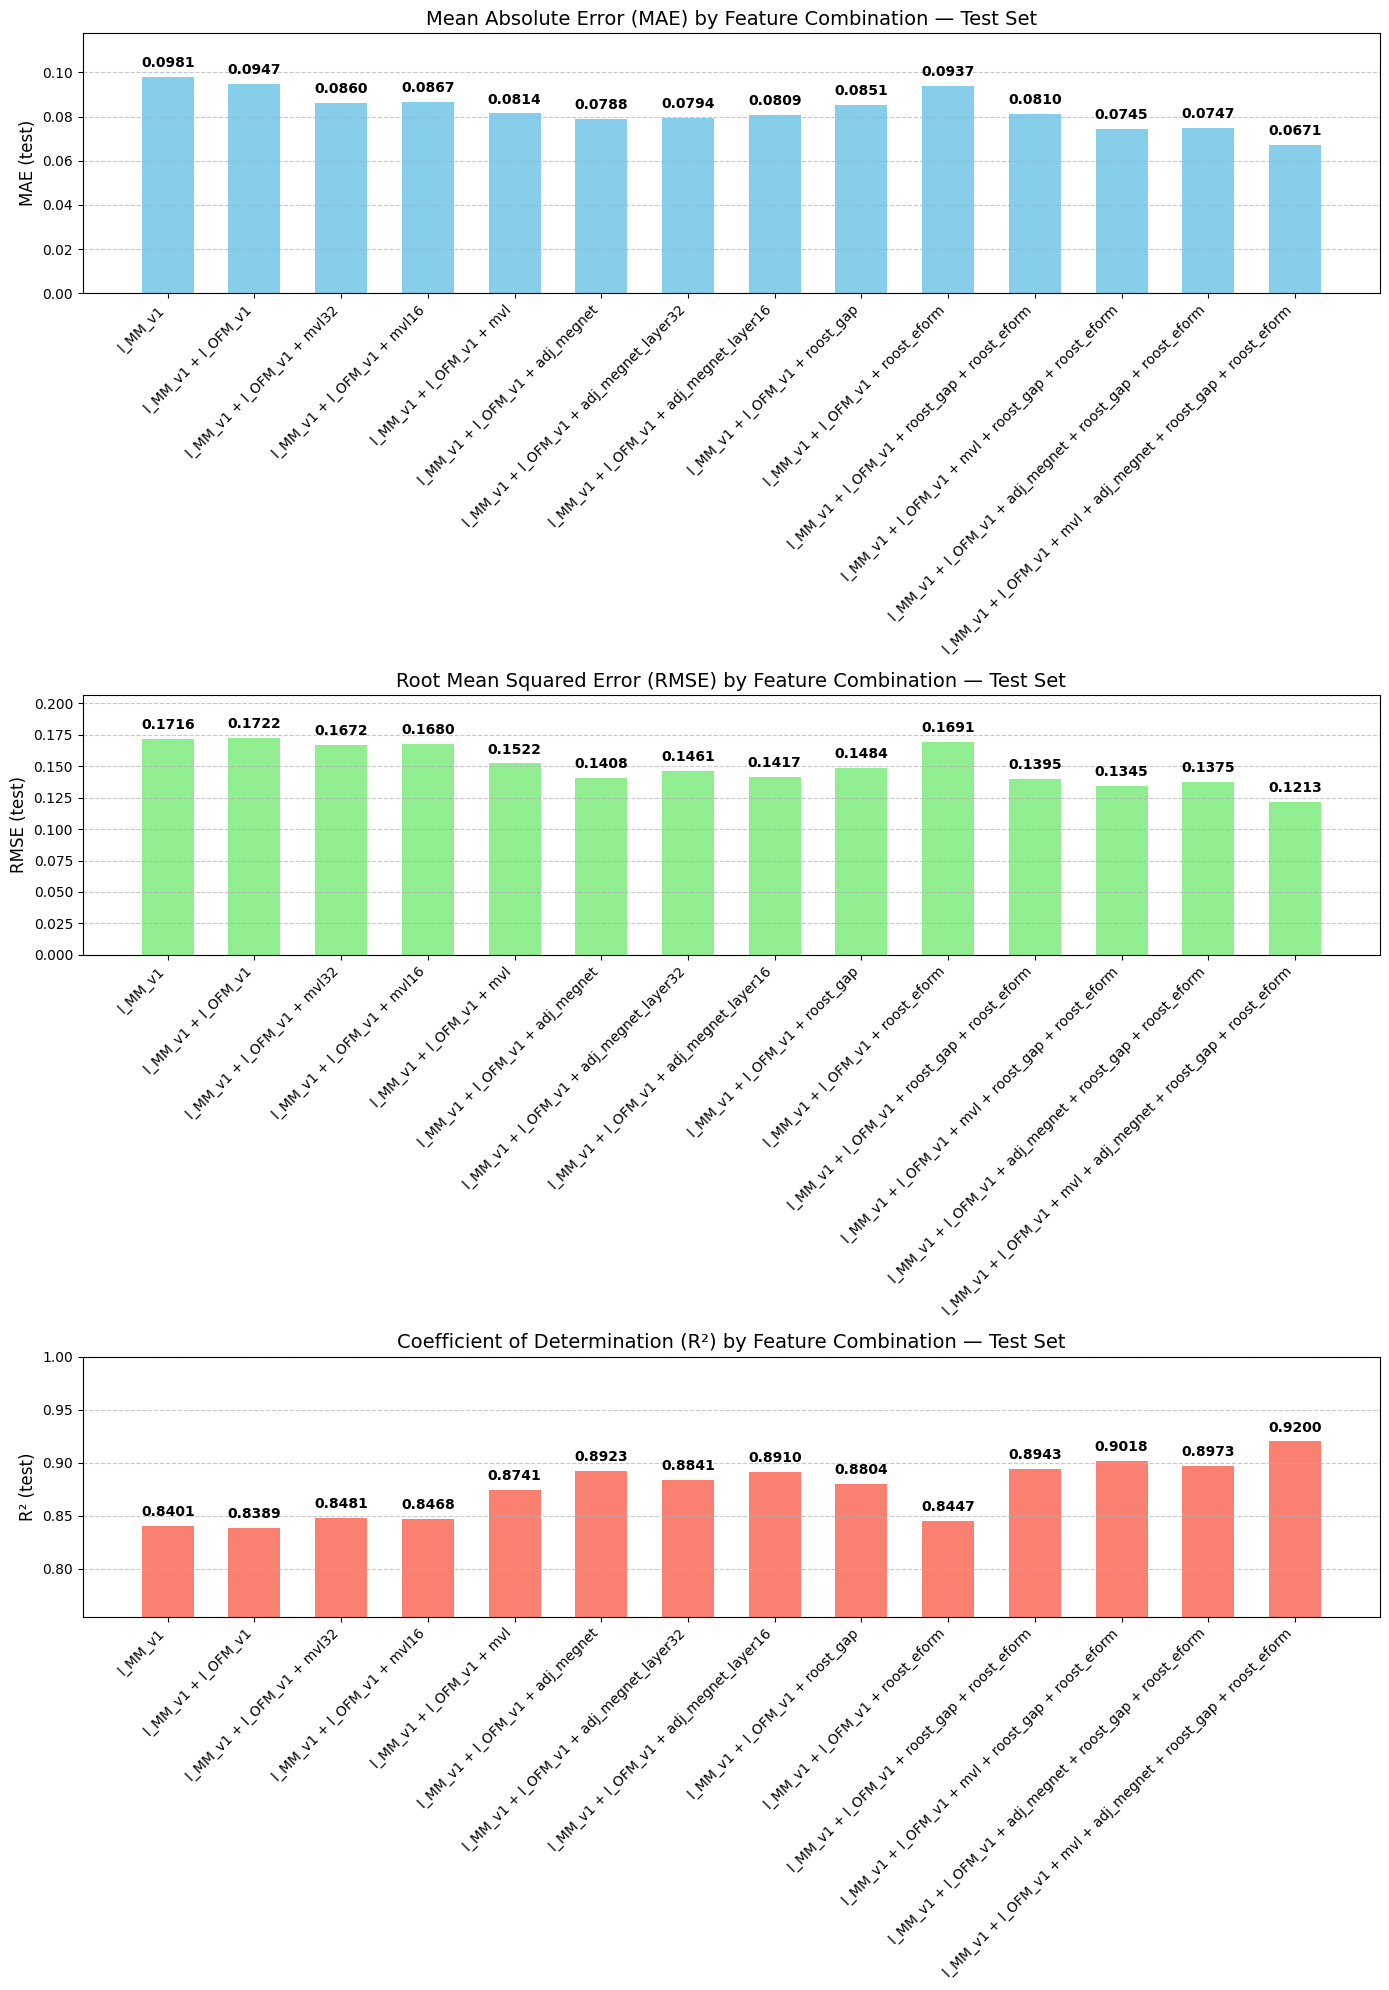

In [10]:
# Extract test-set data for plotting (all combinations are in metrics_df)
combinations = metrics_df['Combination'].astype(str)
mae = metrics_df['MAE_test'].values
rmse = metrics_df['RMSE_test'].values
r2 = metrics_df['R2_test'].values

# Number of feature combinations
num_combinations = len(combinations)
x = np.arange(num_combinations)  # the label locations
width = 0.6  # width of the bars (kept as before for same aesthetics)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 20))

# Function to add text annotations on top of bars
def add_text(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10,
                    fontweight='bold')

# Plot MAE (test)
rects1 = axs[0].bar(x, mae, width, color='skyblue')
axs[0].set_ylabel('MAE (test)', fontsize=12)
axs[0].set_title('Mean Absolute Error (MAE) by Feature Combination — Test Set', fontsize=14)
axs[0].set_xticks(x)
axs[0].set_xticklabels(combinations, rotation=45, ha='right', fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
add_text(axs[0], rects1)
axs[0].set_ylim([0, max(mae) * 1.2])

# Plot RMSE (test)
rects2 = axs[1].bar(x, rmse, width, color='lightgreen')
axs[1].set_ylabel('RMSE (test)', fontsize=12)
axs[1].set_title('Root Mean Squared Error (RMSE) by Feature Combination — Test Set', fontsize=14)
axs[1].set_xticks(x)
axs[1].set_xticklabels(combinations, rotation=45, ha='right', fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
add_text(axs[1], rects2)
axs[1].set_ylim([0, max(rmse) * 1.2])

# Plot R² (test)
rects3 = axs[2].bar(x, r2, width, color='salmon')
axs[2].set_ylabel('R² (test)', fontsize=12)
axs[2].set_title('Coefficient of Determination (R²) by Feature Combination — Test Set', fontsize=14)
axs[2].set_xticks(x)
axs[2].set_xticklabels(combinations, rotation=45, ha='right', fontsize=10)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)
add_text(axs[2], rects3)
# Keep same style as before; ensure lower bound reasonable if R² can be negative
r2_min = r2.min()
axs[2].set_ylim([r2_min * 0.9 if r2_min < 0 else max(r2_min * 0.9, 0.0), 1.0])

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()